In [1]:
# See if required packages are installed and if not, install them
try:
    import quickdraw
except:
    !pip install -q quickdraw -U
    import quickdraw

In [2]:
import datetime, os
import torch

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"
device

image_size = (28, 28)

'cuda'

In [4]:
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized) # recognized=True ensures that only images that have been recognized by Google's AI are loaded.
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png" # Save as .png
        img.get_image(stroke_width=3).resize(image_size).save(filename)

In [5]:
for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True) # 1200 drawings from each class (345 classes)

downloading aircraft carrier from https://storage.googleapis.com/quickdraw_dataset/full/binary/aircraft carrier.bin
download complete
loading aircraft carrier drawings
load complete
downloading airplane from https://storage.googleapis.com/quickdraw_dataset/full/binary/airplane.bin
download complete
loading airplane drawings
load complete
downloading alarm clock from https://storage.googleapis.com/quickdraw_dataset/full/binary/alarm clock.bin
download complete
loading alarm clock drawings
load complete
downloading ambulance from https://storage.googleapis.com/quickdraw_dataset/full/binary/ambulance.bin
download complete
loading ambulance drawings
load complete
downloading angel from https://storage.googleapis.com/quickdraw_dataset/full/binary/angel.bin
download complete
loading angel drawings
load complete
downloading animal migration from https://storage.googleapis.com/quickdraw_dataset/full/binary/animal migration.bin
download complete
loading animal migration drawings
load complete
d

In [ ]:
# Create a transform to go to 1 channel (grayscale) and flip horizontally 50% of the time so the model generalizes better
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),
    ToTensor()
])

In [ ]:
from torchvision import datasets

data = datasets.ImageFolder(root="dataset",
                                  transform=transform,
                                  target_transform=None)

In [47]:
data_features, data_labels = next(iter(data))
data_features.shape

torch.Size([1, 28, 28])

In [69]:
import numpy as np

total_len = len(data)
print(f"Length of the original dataset: {total_len}")
# 80/20 split
n_test = int(0.2 * total_len)

# Shuffle the data before splitting it to ensure that both the train and test data get all classes
indices = np.arange(total_len)
np.random.shuffle(indices)

train_data = torch.utils.data.Subset(data, indices[n_test:])
test_data = torch.utils.data.Subset(data, indices[:n_test])

print(f"Length of the training dataset: {len(train_data)}")
print(f"Length of the testing dataset: {len(test_data)}")

Length of the original dataset: 414000
Length of the training dataset: 331200
Length of the testing dataset: 82800


In [72]:
train_features, train_labels = next(iter(train_data))
train_features.shape

torch.Size([1, 28, 28])

In [73]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

In [74]:
class_names = data.classes
len(class_names), class_names[25]

(345, 'beach')

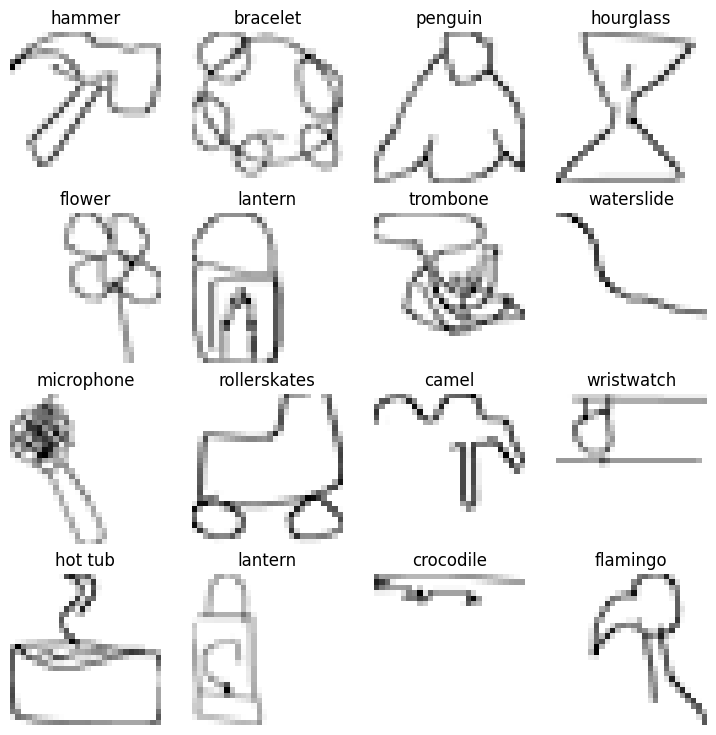

In [75]:
# Visualize Images
# torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, 1 + rows * cols):
  rand_idx = torch.randint(1, len(train_data), size=[1]).item()
  img, label = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  # plt.imshow(img.squeeze().permute(1, 2, 0), cmap="gray") We would have to do this to swap the color channels if it had 3 color channels
  plt.axis(False)
  plt.title(class_names[label])

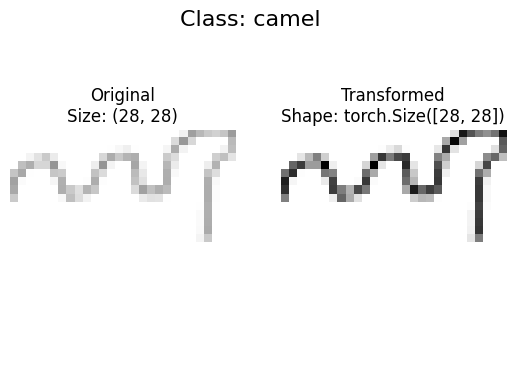

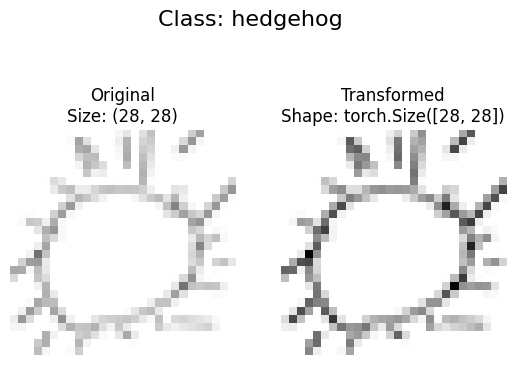

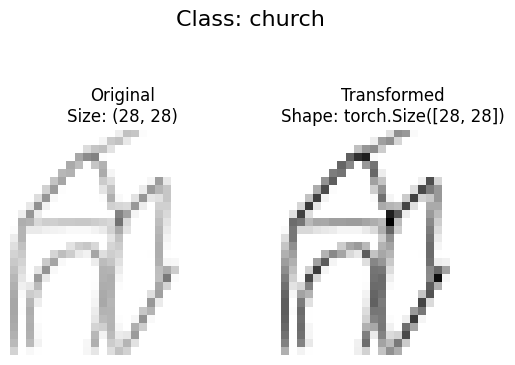

In [76]:
import random
from PIL import Image

def plot_transformed_images(image_paths: list,
                            transform,
                            n=3,
                            seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot the target image
      transformed_image = transform(f).squeeze()
      ax[1].imshow(transformed_image, cmap="gray")
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

image_path = Path("dataset/")
image_path_list = list(image_path.glob("*/*.png"))

plot_transformed_images(image_paths=image_path_list,
                        transform=transform,
                        n=3,
                        seed=None)



In [118]:
class DoodleDetectionModel(nn.Module):
  """This model can predict on the google doodles dataset."""
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.BatchNorm2d(input_shape),
        nn.Conv2d(in_channels=input_shape,
                  out_channels=6,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=6,
                  out_channels=8,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=8,
                  out_channels=10,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=1960,
                  out_features=700),
        nn.BatchNorm1d(700),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=700,
                  out_features=500),
        nn.BatchNorm1d(500),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=500,
                  out_features=400),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=400,
                  out_features=output_shape),
    )

  def forward(self, x):
    return self.classifier(self.conv_block_1(x))

In [88]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  # Loop through the data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X) # Outputs model logits

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Step the optimizer
    optimizer.step()

    # Use softmax activation function for multiclass classification, and get the argmax to find the class index
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [89]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Forward pass
      test_pred_logits = model(X) # outputs model logits

      # Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

In [90]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10,
          device=device):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [125]:
LEARNING_RATE = 5e-4

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = DoodleDetectionModel(input_shape=1,
                      hidden_units=10,
                      output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=LEARNING_RATE)

In [126]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [127]:
from timeit import default_timer as timer

start_time = timer()

model_results = train(model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=10,
      device=device)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 3.3156 | Train acc: 0.2781 | Test loss: 2.7563 | Test acc: 0.3768
Epoch: 1 | Train loss: 2.8000 | Train acc: 0.3612 | Test loss: 2.5512 | Test acc: 0.4156
Epoch: 2 | Train loss: 2.6420 | Train acc: 0.3910 | Test loss: 2.4589 | Test acc: 0.4305
Epoch: 3 | Train loss: 2.5489 | Train acc: 0.4093 | Test loss: 2.3896 | Test acc: 0.4446
Epoch: 4 | Train loss: 2.4816 | Train acc: 0.4208 | Test loss: 2.3262 | Test acc: 0.4551
Epoch: 5 | Train loss: 2.4377 | Train acc: 0.4289 | Test loss: 2.3210 | Test acc: 0.4552
Epoch: 6 | Train loss: 2.4015 | Train acc: 0.4356 | Test loss: 2.2560 | Test acc: 0.4683
Epoch: 7 | Train loss: 2.3746 | Train acc: 0.4401 | Test loss: 2.2658 | Test acc: 0.4659
Epoch: 8 | Train loss: 2.3486 | Train acc: 0.4456 | Test loss: 2.2476 | Test acc: 0.4683
Epoch: 9 | Train loss: 2.3311 | Train acc: 0.4490 | Test loss: 2.2091 | Test acc: 0.4795
Total training time: 679.8598186600002


In [128]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [129]:
import random

# random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

In [130]:
predictions = make_predictions(model=model,
                               data=test_samples,
                               device=device).argmax(dim=1)

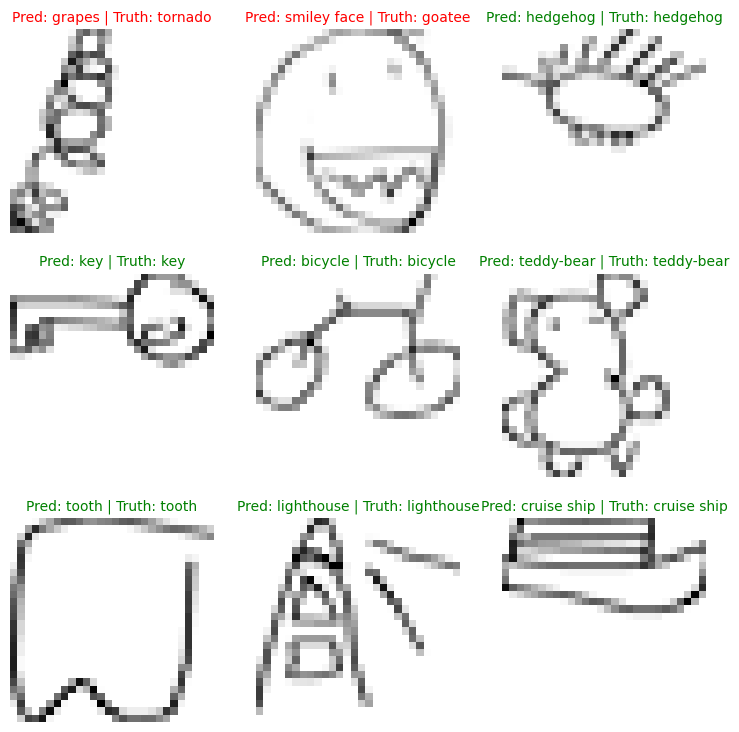

In [131]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i + 1)
  plt.imshow(sample.squeeze(), cmap="gray")
  plt.axis(False)

  pred_label = class_names[predictions[i]]
  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

In [132]:
# Save the model (In Colab, download from colab files)
torch.save(model.state_dict(), "model.pth")